In [2]:
import pandas as pd
import numpy as np
import xarray as xr
import regionmask

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn import metrics
import tensorflow as tf

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Step 1: Renewable Energy data

- **Source:** https://data.open-power-system-data.org/time_series/2019-06-05


- **Description:** This data package contains different kinds of timeseries data relevant for power system modelling, namely electricity consumption (load) for 37 European countries as well as wind and solar power generation and capacities and prices for a growing subset of countries. The timeseries become available at different points in time depending on the sources. The data has been downloaded from the sources, resampled and merged in a large CSV file with hourly resolution. Additionally, the data available at a higher resolution (Some renewables in-feed, 15 minutes) is provided in a separate file. All data processing is conducted in python and pandas and has been documented in the Jupyter notebooks linked below.


#### This dataset is a consolidation from several different sources. Due to different quality standards for different countries, for the example in the current notebook let's use data for Germany (country code = 'DE_')


In [3]:
# energy data file
energy_fn = './data/energy/time_series_60min_singleindex.csv.gz'

# country to be extracted from the energy dataset
country_code = 'DE_'

# function to extract only the needed columns
usecols = lambda colname: colname.startswith('utc') | colname.startswith(country_code)

# reading CSV into a pd.DataFrame, selecting columns with 'usecols'
energy_df = pd.read_csv(energy_fn,
                        usecols=usecols,          
                        parse_dates=['utc_timestamp'],
                        index_col=['utc_timestamp'])

# slicing a period of the data
energy_df = energy_df['2016-01-01 00:00:00':'2018-12-31 23:00:00']
energy_df.head()

,DE_load_actual_entsoe_power_statistics,DE_load_actual_entsoe_transparency,DE_load_forecast_entsoe_transparency,DE_price_day_ahead,DE_solar_capacity,DE_solar_generation_actual,DE_solar_profile,DE_wind_capacity,DE_wind_generation_actual,DE_wind_profile,...,DE_tennet_wind_generation_forecast,DE_tennet_wind_offshore_generation_actual,DE_tennet_wind_onshore_generation_actual,DE_transnetbw_load_actual_entsoe_transparency,DE_transnetbw_load_forecast_entsoe_transparency,DE_transnetbw_solar_generation_actual,DE_transnetbw_solar_generation_forecast,DE_transnetbw_wind_generation_actual,DE_transnetbw_wind_generation_forecast,DE_transnetbw_wind_onshore_generation_actual
utc_timestamp,,,,,,,,,,,,,,,,,,,,,
2016-01-01 00:00:00+00:00,42768.2041,39396.0,38163.0,22.39,39159.0,0.0,0.0,43663.0,8579.0,0.1965,...,4740.0,2263.0,3352.0,4652.0,3892.0,0.0,0.0,24.0,0.0,24.0
2016-01-01 01:00:00+00:00,41154.1122,37718.0,36769.0,20.59,39159.0,0.0,0.0,43663.0,8542.0,0.1957,...,4735.0,2218.0,3280.0,4431.0,3705.0,0.0,0.0,24.0,0.0,24.0
2016-01-01 02:00:00+00:00,39961.7143,36692.0,36452.0,16.81,39159.0,0.0,0.0,43663.0,8443.0,0.1934,...,4795.0,2005.0,3434.0,4325.0,3678.0,0.0,0.0,17.0,0.0,17.0
2016-01-01 03:00:00+00:00,39465.4286,36556.0,36578.0,17.41,39159.0,0.0,0.0,43663.0,8295.0,0.1900,...,4784.0,1930.0,3521.0,4337.0,3803.0,0.0,0.0,20.0,0.0,20.0
2016-01-01 04:00:00+00:00,38810.6224,35890.0,37173.0,17.02,39159.0,0.0,0.0,43663.0,7319.0,0.1676,...,4595.0,1580.0,3324.0,4197.0,3809.0,0.0,0.0,10.0,0.0,10.0


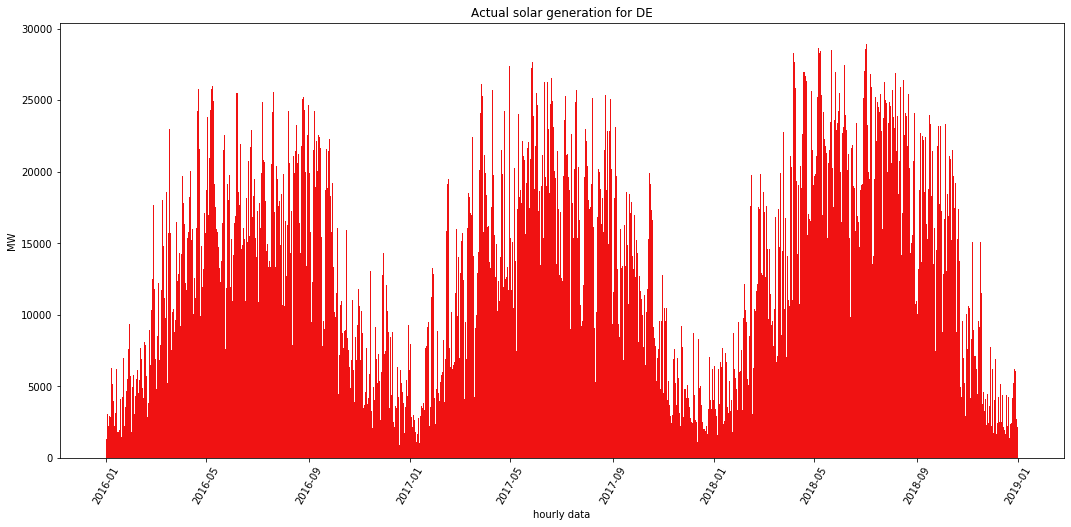

In [4]:
# barplots are slow when many vertical bars have to be drawn, be patient (or change to lineplot)
plt.figure(figsize=(18,8))
plt.bar(energy_df.index, energy_df[f'{country_code}solar_generation_actual'], color='#f01212')
## use this line if impatient
# plt.plot(energy_df.index, energy_df.NL_solar_generation_actual)
plt.xticks(rotation=60)
plt.title(f'Actual solar generation for {country_code[:-1]}')
plt.ylabel('MW')
plt.xlabel('hourly data')
plt.show()

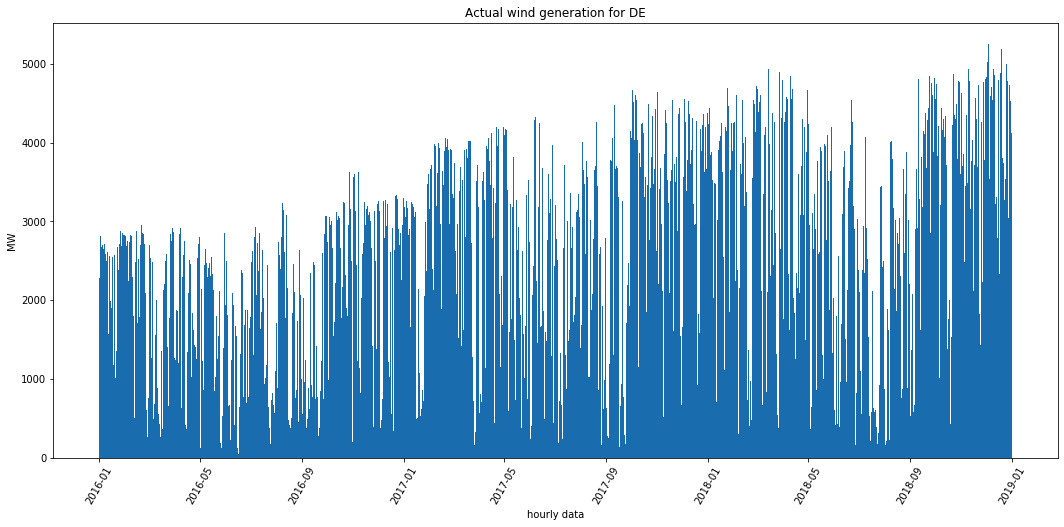

In [5]:
# barplots are slow when many vertical bars have to be drawn, be patient (or change to lineplot)
plt.figure(figsize=(18,8))
plt.bar(energy_df.index, energy_df[f'{country_code}wind_offshore_generation_actual'], color='#196DAE')
## use this line if impatient
# plt.plot(energy_df.index, energy_df.NL_wind_offshore_generation_actual)
plt.xticks(rotation=60)
plt.title(f'Actual wind generation for {country_code[:-1]}')
plt.ylabel('MW')
plt.xlabel('hourly data')
plt.show()

# Step 2: Meteorological data 

- Let's use pre-downloaded hourly data, link provided in README
- Hourly data gives us the same time granularity as in the energy data. We'll slice the data accordingly so both datasets cover the exact same period (and have the same shape)
- Meteorological features for prediction are:

|Variable|Variable Name|
|-------:|------------:|
|t2m|2 metre temperature|
|msl|Mean sea level pressure|
|u10|10 metre U wind component|
|v10|10 metre V wind component|
|u100|100 metre U wind component|
|v100|100 metre V wind component|
|fsr|Forecast surface roughness|
|cdir|Clear-sky direct solar radiation at surface|
|ssrdc|Surface solar radiation downward clear-sky|
|ssrd|Surface solar radiation downwards|
|tisr|TOA incident solar radiation|


In [6]:
# load wx data for each year
wx_data_2016 = xr.open_dataset('./data/weather/era5_DE_hourly_2016.nc')
wx_data_2017 = xr.open_dataset('./data/weather/era5_DE_hourly_2017.nc')
wx_data_2018 = xr.open_dataset('./data/weather/era5_DE_hourly_2018.nc')

# combining wx data, cleaning unused object for memory efficiency
wx_data = xr.concat([wx_data_2016, wx_data_2017, wx_data_2018], dim='time')
del wx_data_2016, wx_data_2017, wx_data_2018

In [7]:
# let's re-use the extract function from previous example
country_mask = regionmask.defined_regions.natural_earth.countries_50.mask(wx_data, 
                                                                          lon_name='longitude', 
                                                                          lat_name='latitude')

def extract_data_for_country(country_name, country_mask, wx_data):
    country_id = regionmask.defined_regions.natural_earth.countries_50.map_keys(country_name)
    wx_data = wx_data.where(country_mask==country_id)
    wx_data = wx_data.dropna('latitude', how='all')
    wx_data = wx_data.dropna('longitude', how='all')
    return wx_data

In [8]:
wx_data = extract_data_for_country('Germany', country_mask, wx_data)

<Figure size 432x288 with 0 Axes>

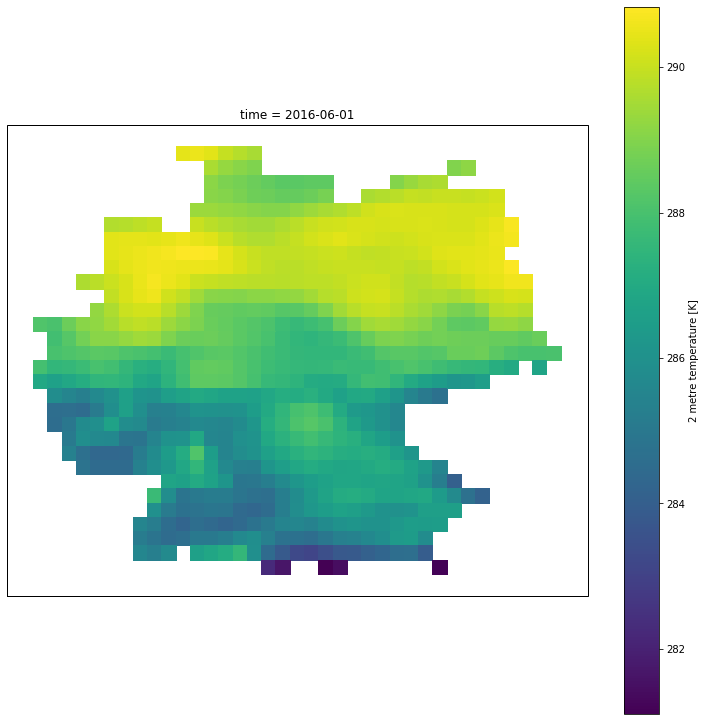

In [9]:
plt.clf()
data_crs = ccrs.PlateCarree()

plt.figure(figsize=(13,13))
data_crs = ccrs.PlateCarree()

ax = plt.axes(projection=data_crs)
wx_data.t2m.sel(time='2016-06-01 00:00:00').plot(ax=ax,transform=data_crs, cmap='viridis')
plt.show()

# Step 3a: Modeling for Wind Energy

- How do the same points from the previous example work in a neural network case?

## Important considerations:
    - Training/*Validation*/Test Split
    - Features to be used
    - Algorithm to choose
        - # layers
        - # units
        - Neural networks hyperparameters
    - Always check your data

In [10]:
train_period = ('2016-01-01 00:00:00','2017-12-31 23:00:00')
valid_period = ('2018-01-01 00:00:00','2018-06-30 23:00:00')
test_period  = ('2018-07-01 00:00:00','2018-12-31 23:00:00')

### Neural Network explanation

In [11]:
# slicing train, valid and test data
features = ['t2m', 'msl', 'u10', 'v10', 'u100', 'v100']

X_train = wx_data[features].sel(time=slice(train_period[0],train_period[1])).mean(axis=(1,2)).to_dataframe()
X_valid = wx_data[features].sel(time=slice(valid_period[0],valid_period[1])).mean(axis=(1,2)).to_dataframe()
X_test = wx_data[features].sel(time=slice(test_period[0],test_period[1])).mean(axis=(1,2)).to_dataframe()

# saving column names for later
cols = X_train.columns

In [12]:
X_train.head()

,t2m,msl,u10,v10,u100,v100
time,,,,,,
0,275.348236,102517.820312,0.584799,1.908262,2.211248,3.509427
1,275.303406,102515.429688,0.641346,1.875305,2.270467,3.401260
2,275.275299,102541.640625,0.680180,1.822950,2.310062,3.261734
3,275.232635,102568.046875,0.818507,1.817452,2.513633,3.168304
4,275.156982,102563.406250,0.875309,1.783264,2.605804,3.015348


In [13]:
# scaling X data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.values)
X_valid = scaler.transform(X_valid.values)
X_test = scaler.transform(X_test.values)

X_train = pd.DataFrame(data=X_train, columns=cols)
X_train.index.names = ['time']

X_valid = pd.DataFrame(data=X_valid, columns=cols)
X_valid.index.names = ['time']

X_test = pd.DataFrame(data=X_test, columns=cols)
X_test.index.names = ['time']

In [14]:
X_train.head()

,t2m,msl,u10,v10,u100,v100
time,,,,,,
0,-1.005786,0.937518,-0.246381,0.741025,0.048351,0.844760
1,-1.011773,0.934837,-0.221625,0.721853,0.063652,0.807853
2,-1.015527,0.964235,-0.204623,0.691396,0.073883,0.760248
3,-1.021225,0.993853,-0.144064,0.688198,0.126482,0.728369
4,-1.031328,0.988648,-0.119195,0.668310,0.150298,0.676181


In [15]:
X_train.shape, X_valid.shape, X_test.shape 

((17544, 6), (4344, 6), (4416, 6))

In [16]:
# Slicing Train, Test and Validation Sets
labels = [f'{country_code}wind_onshore_generation_actual']
Y_train = energy_df[labels][train_period[0]:train_period[1]]
Y_valid = energy_df[labels][valid_period[0]:valid_period[1]]
Y_test = energy_df[labels][test_period[0]:test_period[1]]

Y_train.shape, Y_valid.shape, Y_test.shape

((17544, 1), (4344, 1), (4416, 1))

In [17]:
# filtering some NaN's present in labels

X_train = X_train[Y_train.notnull().values]
Y_train = Y_train[Y_train.notnull().values]

X_valid = X_valid[Y_valid.notnull().values]
Y_valid = Y_valid[Y_valid.notnull().values]

X_test = X_test[Y_test.notnull().values]
Y_test = Y_test[Y_test.notnull().values]

X_train.shape, X_valid.shape, X_test.shape,Y_train.shape, Y_valid.shape, Y_test.shape

((17544, 6), (4344, 6), (4416, 6), (17544, 1), (4344, 1), (4416, 1))

# Some comments on Keras module


- Documentation: https://www.tensorflow.org/api_docs/python/tf/keras


#### Activation functions: https://www.tensorflow.org/api_docs/python/tf/keras/activations
- Let's use the 'rectified linear unit' (relu) activation function

#### Optimizers:
- Let's use the Adam optmizer: https://www.tensorflow.org/api_docs/python/tf/keras/optimizers
    - Adam optimization is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments. According to the paper [Adam: A Method for Stochastic Optimization. Kingma et al., 2014,](http://arxiv.org/abs/1412.6980) the method is "computationally efficient, has little memory requirement, invariant to diagonal rescaling of gradients, and is well suited for problems that are large in terms of data/parameters".
    
- we won't change the default parameters of the Adam optmizer:
```
    __init__(
        learning_rate=0.001,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-07,
        amsgrad=False,
        name='Adam',
        **kwargs
        )
```

#### Initializers: https://www.tensorflow.org/api_docs/python/tf/keras/initializers
- Let's use a RandomNormal() initalizer


### Why do we have to define `Checkpoint` and `Earlystop`?


In [18]:
activation = tf.keras.activations.relu
optimizer = tf.keras.optimizers.Adam()
initializer = tf.keras.initializers.RandomNormal(dtype=tf.dtypes.float32)
loss = tf.keras.losses.MeanAbsoluteError()

num_hidden_layers = 10
num_units = 50

model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(num_units, 
                                kernel_initializer=initializer,
                                input_dim=X_train.shape[1]))

for layers in range(num_hidden_layers):
    model.add(tf.keras.layers.Dense(num_units, 
                                    kernel_initializer=initializer,
                                    activation=activation))
    
model.add(tf.keras.layers.Dense(1, 
                                kernel_initializer=initializer,
                                activation=activation))

model.compile(loss=loss,
              optimizer=optimizer,
              metrics=[loss])

print(model.summary())

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                350       
_________________________________________________________________
dense_1 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_3 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_4 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_5 (Dense)              (None, 50)                2550      
____

In [19]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('best_model_wind.h5',
                                                monitor="val_loss",
                                                verbose=0,
                                                save_weights_only=True,
                                                mode="auto",
                                                save_freq=1)

earlystop = tf.keras.callbacks.EarlyStopping(monitor="val_loss", 
                                             min_delta=0, 
                                             patience=10, 
                                             verbose=0, 
                                             mode="auto")

history = model.fit(X_train.values, 
                    Y_train.values.reshape(-1),
                    validation_data=(X_valid, Y_valid),
                    epochs = 100, 
                    batch_size=512,
                    callbacks=[checkpoint, earlystop])

Train on 17544 samples, validate on 4344 samples
Epoch 1/100
17544/17544 [==============================] - 1s 71us/sample - loss: 8567.4065 - mean_absolute_error: 8565.1113 - val_loss: 10558.2372 - val_mean_absolute_error: 10580.5771
Epoch 2/100
17544/17544 [==============================] - 1s 44us/sample - loss: 8331.0610 - mean_absolute_error: 8281.4307 - val_loss: 7549.6106 - val_mean_absolute_error: 7531.5269
Epoch 3/100
17544/17544 [==============================] - 1s 43us/sample - loss: 3692.4156 - mean_absolute_error: 3667.8147 - val_loss: 4477.6210 - val_mean_absolute_error: 4458.6309
Epoch 4/100
17544/17544 [==============================] - 1s 43us/sample - loss: 2347.6486 - mean_absolute_error: 2342.3352 - val_loss: 3788.4515 - val_mean_absolute_error: 3794.2612
Epoch 5/100
17544/17544 [==============================] - 1s 45us/sample - loss: 2037.5221 - mean_absolute_error: 2038.5997 - val_loss: 3717.7899 - val_mean_absolute_error: 3707.4402
Epoch 6/100
17544/17544 [====

### Before testing the model, let's analyze what happened during training

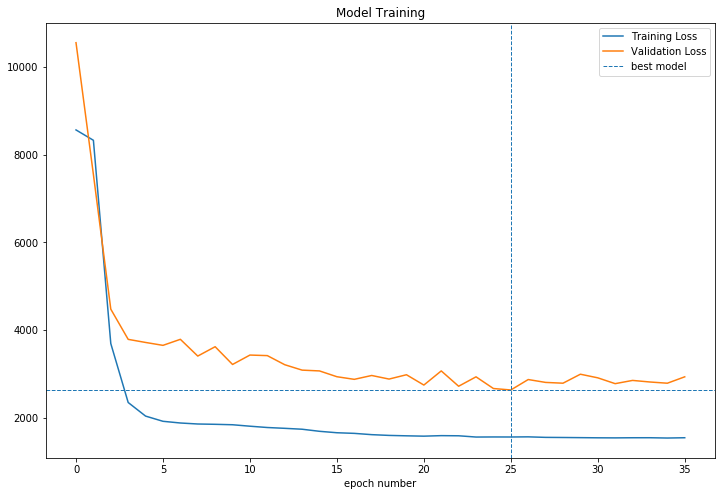

In [20]:
history.history.keys()
plt.figure(figsize=(12,8))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Training')
plt.xlabel('epoch number')

plt.axvline(np.argmin(history.history['val_loss']), 
            linestyle='--',
            linewidth=1)

plt.axhline(np.min(history.history['val_loss']), 
            linestyle='--',
            linewidth=1,
            label='best model')

plt.legend()
plt.show()

### Ok now let's predict

In [21]:
model.load_weights('best_model_wind.h5')
Y_pred = model.predict(X_test)

In [22]:
mae = metrics.mean_absolute_error(Y_test, Y_pred)
mse = metrics.mean_squared_error(Y_test, Y_pred)
msle = metrics.mean_squared_log_error(Y_test, Y_pred)
r2 = metrics.r2_score(Y_test, Y_pred)

In [23]:
print(f"Mean Absolute Error - MAE = {mae}")
print(f"Mean Squared Error - MSE = {mse}")
print(f"Mean Squared Log Error - MSLE = {msle}")
print(f"R**2 Score - R2 = {r2}")


Mean Absolute Error - MAE = 2641.919741395591
Mean Squared Error - MSE = 12527197.520717524
Mean Squared Log Error - MSLE = 0.2069884313174646
R**2 Score - R2 = 0.8028170624638639


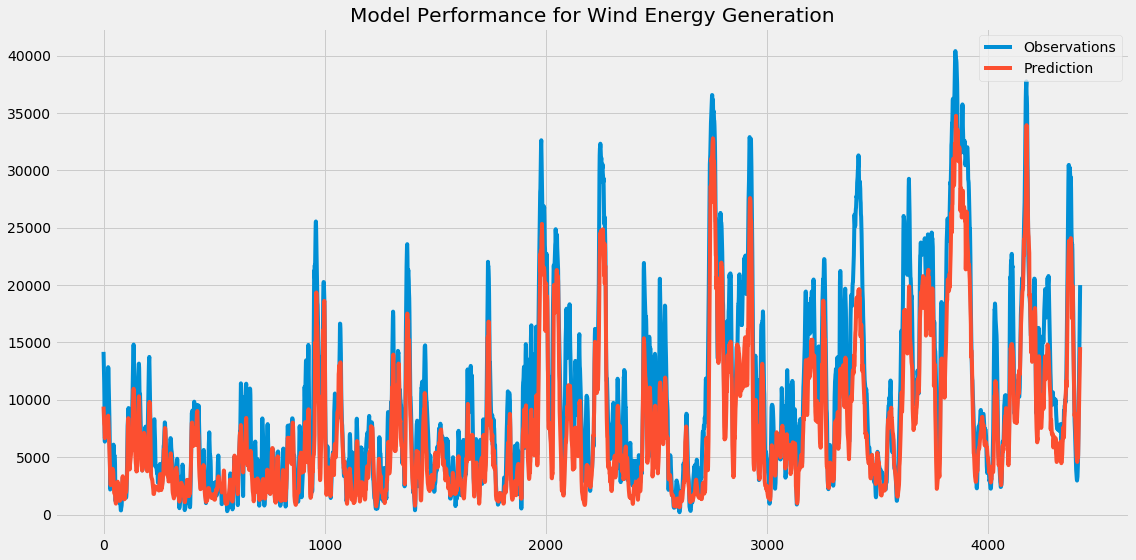

In [24]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(16,8))
plt.plot(Y_test.values, label='Observations')
plt.plot(Y_pred, label='Prediction')
plt.legend()
plt.title('Model Performance for Wind Energy Generation')
plt.tight_layout()
plt.show()

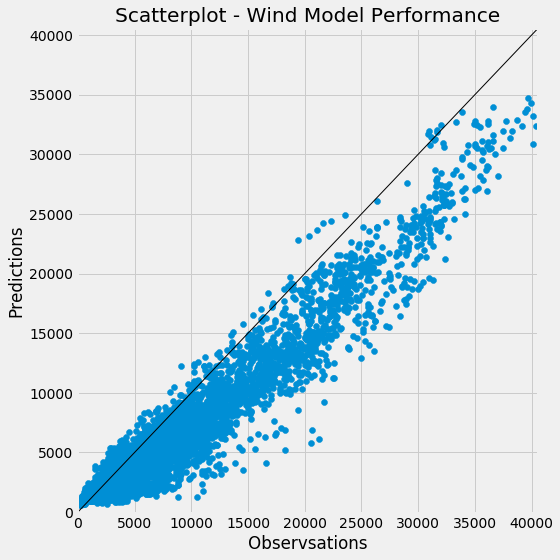

In [25]:
plt.figure(figsize=(8,8))
plt.scatter(Y_test, Y_pred)
l_min, l_max = -100,  np.max([np.max(Y_test.values),np.max(Y_pred)])+200
plt.xlim([l_min, l_max])
plt.ylim([l_min, l_max])
plt.plot([l_min, l_max],[l_min, l_max], color='k', lw=1)
plt.title('Scatterplot - Wind Model Performance')
plt.xlabel('Observsations')
plt.ylabel('Predictions')
plt.tight_layout()
plt.show()

# Step 3b: Modeling for Solar Energy

- Let's use different meteorological features now:

In [26]:
# slicing train, valid and test data
features = ['t2m', 'cdir', 'ssrdc', 'ssrd', 'tisr', 'msl'] 

X_train = wx_data[features].sel(time=slice(train_period[0],train_period[1])).mean(axis=(1,2)).to_dataframe()
X_valid = wx_data[features].sel(time=slice(valid_period[0],valid_period[1])).mean(axis=(1,2)).to_dataframe()
X_test = wx_data[features].sel(time=slice(test_period[0],test_period[1])).mean(axis=(1,2)).to_dataframe()

# saving column names for later
cols = X_train.columns

In [27]:
X_train.head()

,t2m,cdir,ssrdc,ssrd,tisr,msl
time,,,,,,
0,275.348236,0.0,-0.125,-1.875,-0.25,102517.820312
1,275.303406,0.0,-0.125,-1.875,-0.25,102515.429688
2,275.275299,0.0,-0.125,-1.875,-0.25,102541.640625
3,275.232635,0.0,-0.125,-1.875,-0.25,102568.046875
4,275.156982,0.0,-0.125,-1.875,-0.25,102563.406250


In [28]:
# scaling X data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.values)
X_valid = scaler.transform(X_valid.values)
X_test = scaler.transform(X_test.values)

X_train = pd.DataFrame(data=X_train, columns=cols)
X_train.index.names = ['time']

X_valid = pd.DataFrame(data=X_valid, columns=cols)
X_valid.index.names = ['time']

X_test = pd.DataFrame(data=X_test, columns=cols)
X_test.index.names = ['time']

In [29]:
X_train.tail()

,t2m,cdir,ssrdc,ssrd,tisr,msl
time,,,,,,
17539,-0.027144,-0.686205,-0.721906,-0.676367,-0.773319,-1.715527
17540,-0.071753,-0.686205,-0.721906,-0.676367,-0.773319,-1.753785
17541,-0.086768,-0.686205,-0.721906,-0.676367,-0.773319,-1.785304
17542,-0.119215,-0.686205,-0.721906,-0.676367,-0.773319,-1.802487
17543,-0.135151,-0.686205,-0.721906,-0.676367,-0.773319,-1.795083


In [30]:
# Slicing Train, Test and Validation Sets
labels = [f'{country_code}solar_generation_actual']
Y_train = energy_df[labels][train_period[0]:train_period[1]]
Y_valid = energy_df[labels][valid_period[0]:valid_period[1]]
Y_test = energy_df[labels][test_period[0]:test_period[1]]

Y_train.shape, Y_valid.shape, Y_test.shape

((17544, 1), (4344, 1), (4416, 1))

In [31]:
# filtering some NaN's present in labels

X_train = X_train[Y_train.notnull().values]
Y_train = Y_train[Y_train.notnull().values]

X_valid = X_valid[Y_valid.notnull().values]
Y_valid = Y_valid[Y_valid.notnull().values]

X_test = X_test[Y_test.notnull().values]
Y_test = Y_test[Y_test.notnull().values]

X_train.shape, X_valid.shape, X_test.shape,Y_train.shape, Y_valid.shape, Y_test.shape

((17544, 6), (4344, 6), (4416, 6), (17544, 1), (4344, 1), (4416, 1))

In [ ]:
activation = tf.keras.activations.relu
optimizer = tf.keras.optimizers.Adam()
initializer = tf.keras.initializers.RandomNormal(dtype=tf.dtypes.float32)
loss = tf.keras.losses.MeanAbsoluteError()

num_hidden_layers = 10
num_units = 80

model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(num_units, 
                                kernel_initializer=initializer,
                                input_dim=X_train.shape[1]))

for layers in range(num_hidden_layers):
    model.add(tf.keras.layers.Dense(num_units, 
                                    kernel_initializer=initializer,
                                    activation=activation))
    
model.add(tf.keras.layers.Dense(1, 
                                kernel_initializer=initializer,
                                activation=activation))

model.compile(loss=loss,
              optimizer=optimizer,
              metrics=[loss])

print(model.summary())

checkpoint = tf.keras.callbacks.ModelCheckpoint('best_model_solar.h5',
                                                monitor="val_loss",
                                                verbose=0,
                                                save_weights_only=True,
                                                mode="auto",
                                                save_freq=1)

earlystop = tf.keras.callbacks.EarlyStopping(monitor="val_loss", 
                                             min_delta=0, 
                                             patience=10, 
                                             verbose=0, 
                                             mode="auto")

history = model.fit(X_train.values, 
                    Y_train.values.reshape(-1),
                    validation_data=(X_valid, Y_valid),
                    epochs = 100, 
                    batch_size=512,
                    callbacks=[checkpoint, earlystop])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 80)                560       
_________________________________________________________________
dense_13 (Dense)             (None, 80)                6480      
_________________________________________________________________
dense_14 (Dense)             (None, 80)                6480      
_________________________________________________________________
dense_15 (Dense)             (None, 80)                6480      
_________________________________________________________________
dense_16 (Dense)             (None, 80)                6480      
_________________________________________________________________
dense_17 (Dense)             (None, 80)                6480      
_________________________________________________________________
dense_18 (Dense)             (None, 80)               

Epoch 33/100
17544/17544 [==============================] - 1s 46us/sample - loss: 967.6185 - mean_absolute_error: 973.3062 - val_loss: 1212.1698 - val_mean_absolute_error: 1219.2808
Epoch 34/100
17544/17544 [==============================] - 1s 45us/sample - loss: 969.3900 - mean_absolute_error: 968.7509 - val_loss: 1197.7759 - val_mean_absolute_error: 1208.9397
Epoch 35/100
17544/17544 [==============================] - 1s 47us/sample - loss: 971.0589 - mean_absolute_error: 966.5569 - val_loss: 1202.3094 - val_mean_absolute_error: 1201.5792
Epoch 36/100
17544/17544 [==============================] - 1s 53us/sample - loss: 967.9443 - mean_absolute_error: 967.1193 - val_loss: 1189.6910 - val_mean_absolute_error: 1196.1964
Epoch 37/100
17544/17544 [==============================] - 1s 46us/sample - loss: 961.7362 - mean_absolute_error: 960.7018 - val_loss: 1202.9397 - val_mean_absolute_error: 1201.7194
Epoch 38/100
17544/17544 [==============================] - 1s 46us/sample - loss: 96

In [ ]:
model.load_weights('best_model_solar.h5')
Y_pred = model.predict(X_test)
mae = metrics.mean_absolute_error(Y_test, Y_pred)
mse = metrics.mean_squared_error(Y_test, Y_pred)
msle = metrics.mean_squared_log_error(Y_test, Y_pred)
r2 = metrics.r2_score(Y_test, Y_pred)
print(f"Mean Absolute Error - MAE = {mae}")
print(f"Mean Squared Error - MSE = {mse}")
print(f"Mean Squared Log Error - MSLE = {msle}")
print(f"R**2 Score - R2 = {r2}")

In [ ]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(16,8))
plt.plot(Y_test.values, label='Observations')
plt.plot(Y_pred, label='Prediction', alpha=0.65)
plt.legend()
plt.title('Model Performance for Solar Energy Generation')
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(8,8))
plt.scatter(Y_test, Y_pred)
l_min, l_max = -600,  np.max([np.max(Y_test.values),np.max(Y_pred)])+200
plt.xlim(l_min, l_max)
plt.ylim(l_min, l_max)
plt.plot([l_min, l_max],[l_min, l_max], color='k', lw=1)
plt.title('Scatterplot - Solar Model Performance')
plt.xlabel('Observsations')
plt.ylabel('Predictions')
plt.tight_layout()
plt.show()

In [ ]:
l_min